In [1]:
import hashlib
import time
import statistics
import secrets
import math
import os

import numpy as np
import matplotlib.pyplot as plt

# Optional: SciPy for an exact KS test
try:
    from scipy.stats import kstest
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False


def solve_pow(message: bytes, target_zeros: int) -> float:
    """
    Find a nonce such that SHA256(message || nonce) begins with target_zeros hex '0' chars.
    Returns the elapsed time (seconds).
    """
    prefix = "0" * target_zeros
    nonce = 0
    start = time.perf_counter()

    while True:
        data = message + nonce.to_bytes(8, "little", signed=False)
        h = hashlib.sha256(data).hexdigest()
        if h.startswith(prefix):
            return time.perf_counter() - start
        nonce += 1


def ks_test_exponential(times: list[float]):
    """
    Fit Exp(lambda) with lambda = 1/mean, then do a 1-sample KS test.
    Returns (lambda_hat, D, p_value, note).
    """
    x = np.array(times, dtype=float)
    mean_t = float(x.mean())
    lam = 1.0 / mean_t if mean_t > 0 else float("inf")

    if SCIPY_AVAILABLE:
        # scipy's "expon" uses scale = mean
        D, p = kstest(x, "expon", args=(0, mean_t))
        return lam, float(D), float(p), "KS exact (SciPy)"

    # If SciPy isn't available, we skip the formal KS p-value.
    return lam, None, None, "KS skipped (SciPy not installed)"


def plot_hist_and_cdf(times: list[float], out_dir="pow_plots"):
    os.makedirs(out_dir, exist_ok=True)
    x = np.array(times, dtype=float)
    mean_t = float(x.mean())
    lam = 1.0 / mean_t if mean_t > 0 else 0.0

    # Histogram + fitted exponential density
    plt.figure()
    plt.hist(x, bins=20, density=True)
    xs = np.linspace(0, max(x) * 1.05, 400)
    ys = lam * np.exp(-lam * xs)
    plt.plot(xs, ys)
    plt.title("PoW solve-time histogram (k=4) + fitted exponential")
    plt.xlabel("Solve time (s)")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "hist_k4.png"), dpi=160)
    plt.close()

    # Empirical CDF vs fitted exponential CDF
    plt.figure()
    xs_sorted = np.sort(x)
    n = len(xs_sorted)
    Fn = np.arange(1, n + 1) / n
    Fexp = 1.0 - np.exp(-lam * xs_sorted)
    plt.step(xs_sorted, Fn, where="post", label="Empirical CDF")
    plt.plot(xs_sorted, Fexp, label="Fitted exponential CDF")
    plt.title("CDF check (k=4)")
    plt.xlabel("Solve time (s)")
    plt.ylabel("CDF")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "cdf_k4.png"), dpi=160)
    plt.close()

    print(f"Saved plots in: {os.path.abspath(out_dir)}")
    print(" - hist_k4.png")
    print(" - cdf_k4.png")


if __name__ == "__main__":
    TARGET_ZEROS = 4
    TRIALS = 200

    durations = []
    for _ in range(TRIALS):
        # Fresh challenge each trial (more realistic + more independent)
        msg = b"challenge|" + secrets.token_bytes(16)
        durations.append(solve_pow(msg, TARGET_ZEROS))

    print("=== PoW experiment (SHA-256) ===")
    print(f"Trials: {TRIALS}")
    print(f"Min:  {min(durations):.6f} s")
    print(f"Max:  {max(durations):.6f} s")
    print(f"Mean: {statistics.mean(durations):.6f} s")
    print(f"Std:  {statistics.stdev(durations):.6f} s")

    lam, D, p, note = ks_test_exponential(durations)
    print("\n=== Exponential check ===")
    print(f"lambda_hat (1/mean): {lam:.4f} 1/s")
    print(f"Method: {note}")
    if D is not None:
        print(f"KS statistic D: {D:.4f}")
        print(f"KS p-value:     {p:.4f}")

    plot_hist_and_cdf(durations, out_dir="pow_plots")


=== PoW experiment (SHA-256) ===
Trials: 200
Min:  0.000061 s
Max:  0.679299 s
Mean: 0.070994 s
Std:  0.083880 s

=== Exponential check ===
lambda_hat (1/mean): 14.0856 1/s
Method: KS exact (SciPy)
KS statistic D: 0.0650
KS p-value:     0.3511
Saved plots in: /content/pow_plots
 - hist_k4.png
 - cdf_k4.png



Using SHA-256 and a proof-of-work condition of 4 leading hexadecimal zeros, we measured the time-to-solution over 200 independent trials. The observed solve times are highly variable, which is expected for a PoW process. Fitting an exponential model with
𝜆
=1
/
𝑡
ˉ
λ=1/
t
ˉ
 gives
𝜆
^
≈
14.09

s
−
1
λ
^
≈14.09s
−1
. A Kolmogorov–Smirnov test against the fitted exponential distribution yields
𝐷
=
0.065
D=0.065 and
𝑝
=
0.351
p=0.351, so at
𝛼
=
0.05
α=0.05 we fail to reject the exponential hypothesis. Therefore, the experiment supports the theoretical expectation that PoW behaves like repeated Bernoulli trials, producing an approximately exponential waiting-time distribution.

We try now with 500 trials and 1000 trials.

In [2]:
import os
import csv
import statistics
import secrets

# Assume the following already exist from your previous code:
# - solve_pow(message: bytes, target_zeros: int) -> float
# - ks_test_exponential(times: list[float]) -> (lam, D, p, note)
# - plot_hist_and_cdf(times: list[float], out_dir="pow_plots")

if __name__ == "__main__":
    TARGET_ZEROS = 4
    TRIALS_LIST = [200, 500, 1000]

    all_summaries = []

    for TRIALS in TRIALS_LIST:
        durations = []
        for _ in range(TRIALS):
            msg = b"challenge|" + secrets.token_bytes(16)
            durations.append(solve_pow(msg, TARGET_ZEROS))

        # Basic stats
        min_t = min(durations)
        max_t = max(durations)
        mean_t = statistics.mean(durations)
        std_t = statistics.stdev(durations) if TRIALS > 1 else 0.0

        # Exponential check
        lam, D, p, note = ks_test_exponential(durations)

        print("\n==============================")
        print(f"PoW experiment (SHA-256) — Trials: {TRIALS}, k={TARGET_ZEROS}")
        print(f"Min:  {min_t:.6f} s")
        print(f"Max:  {max_t:.6f} s")
        print(f"Mean: {mean_t:.6f} s")
        print(f"Std:  {std_t:.6f} s")
        print("\nExponential check")
        print(f"lambda_hat (1/mean): {lam:.4f} 1/s")
        print(f"Method: {note}")
        if D is not None:
            print(f"KS statistic D: {D:.4f}")
        if p is not None:
            print(f"KS p-value:     {p:.4f}")

        # Save plots per trial count
        out_dir = f"pow_plots_{TRIALS}"
        plot_hist_and_cdf(durations, out_dir=out_dir)

        # Save durations as CSV
        os.makedirs(out_dir, exist_ok=True)
        csv_path = os.path.join(out_dir, f"durations_k{TARGET_ZEROS}_{TRIALS}.csv")
        with open(csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["run_index", "time_seconds"])
            for i, t in enumerate(durations):
                w.writerow([i, t])
        print(f"Saved durations CSV: {os.path.abspath(csv_path)}")

        all_summaries.append({
            "trials": TRIALS,
            "k": TARGET_ZEROS,
            "min": min_t,
            "max": max_t,
            "mean": mean_t,
            "std": std_t,
            "lambda_hat": lam,
            "ks_D": D,
            "ks_p": p,
            "ks_note": note
        })

    # Print a compact summary table
    print("\n==============================")
    print("Summary (all runs)")
    for s in all_summaries:
        p_str = f"{s['ks_p']:.4f}" if s["ks_p"] is not None else "N/A"
        D_str = f"{s['ks_D']:.4f}" if s["ks_D"] is not None else "N/A"
        print(
            f"Trials={s['trials']:4d} | mean={s['mean']:.6f}s | std={s['std']:.6f}s | "
            f"lambda={s['lambda_hat']:.3f} | KS D={D_str} | p={p_str}"
        )



PoW experiment (SHA-256) — Trials: 200, k=4
Min:  0.000412 s
Max:  0.274607 s
Mean: 0.047628 s
Std:  0.048189 s

Exponential check
lambda_hat (1/mean): 20.9959 1/s
Method: KS exact (SciPy)
KS statistic D: 0.0598
KS p-value:     0.4541
Saved plots in: /content/pow_plots_200
 - hist_k4.png
 - cdf_k4.png
Saved durations CSV: /content/pow_plots_200/durations_k4_200.csv

PoW experiment (SHA-256) — Trials: 500, k=4
Min:  0.000025 s
Max:  0.346489 s
Mean: 0.051083 s
Std:  0.051189 s

Exponential check
lambda_hat (1/mean): 19.5758 1/s
Method: KS exact (SciPy)
KS statistic D: 0.0357
KS p-value:     0.5339
Saved plots in: /content/pow_plots_500
 - hist_k4.png
 - cdf_k4.png
Saved durations CSV: /content/pow_plots_500/durations_k4_500.csv

PoW experiment (SHA-256) — Trials: 1000, k=4
Min:  0.000111 s
Max:  0.415124 s
Mean: 0.050571 s
Std:  0.052451 s

Exponential check
lambda_hat (1/mean): 19.7743 1/s
Method: KS exact (SciPy)
KS statistic D: 0.0245
KS p-value:     0.5747
Saved plots in: /content/

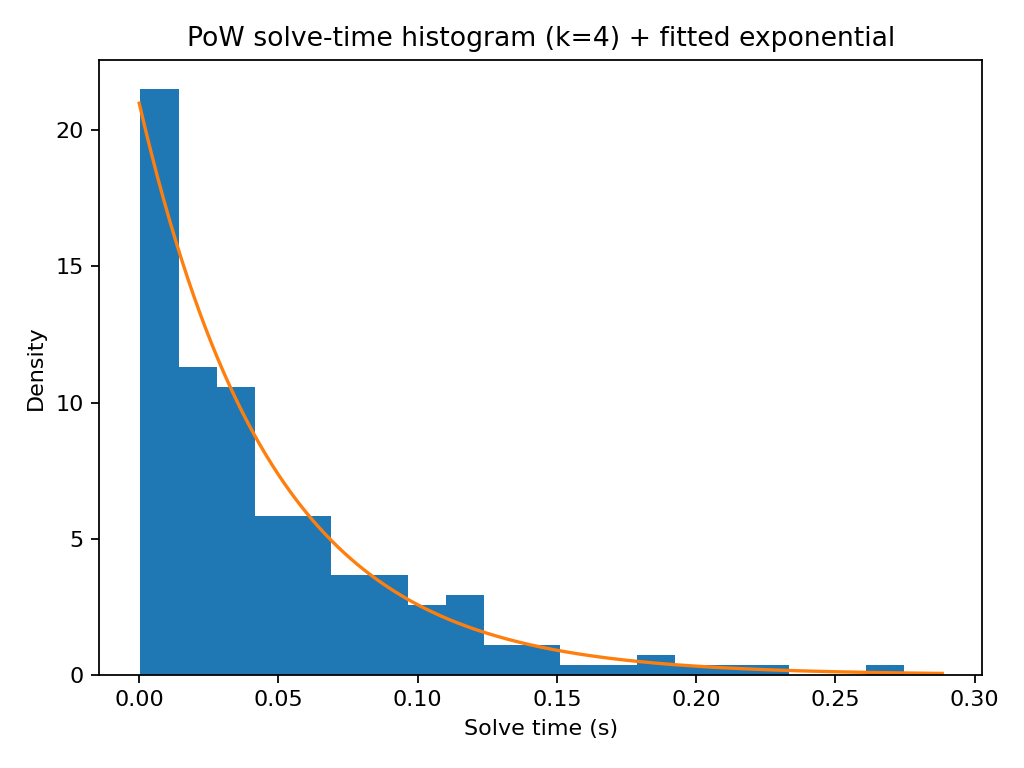

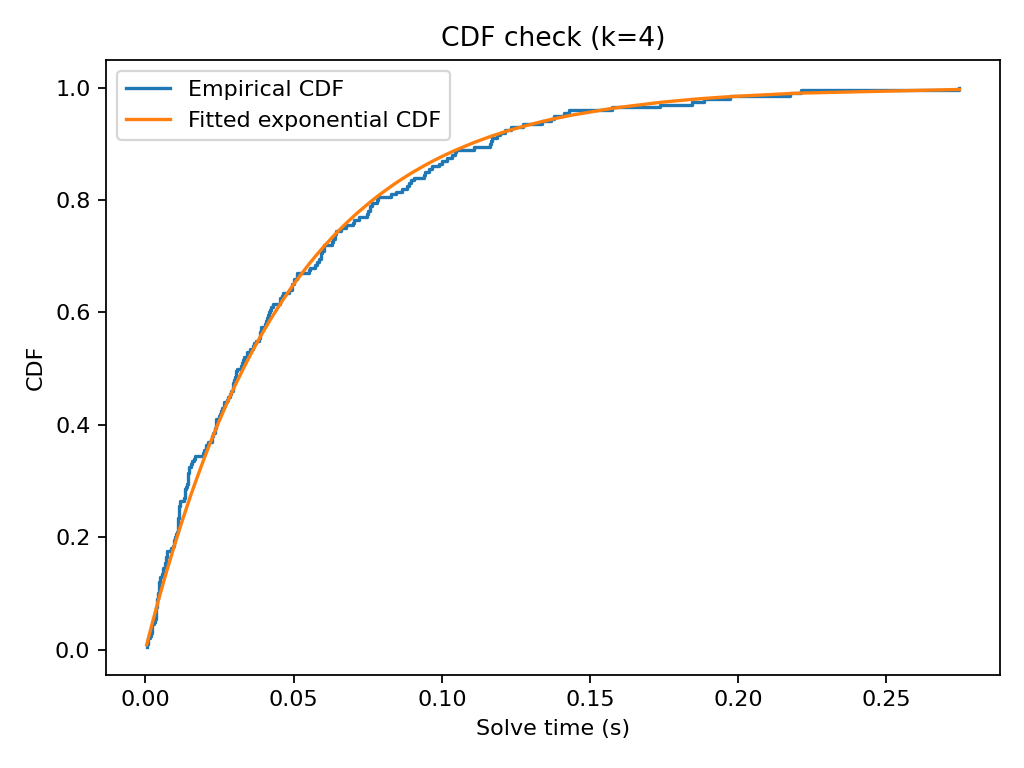

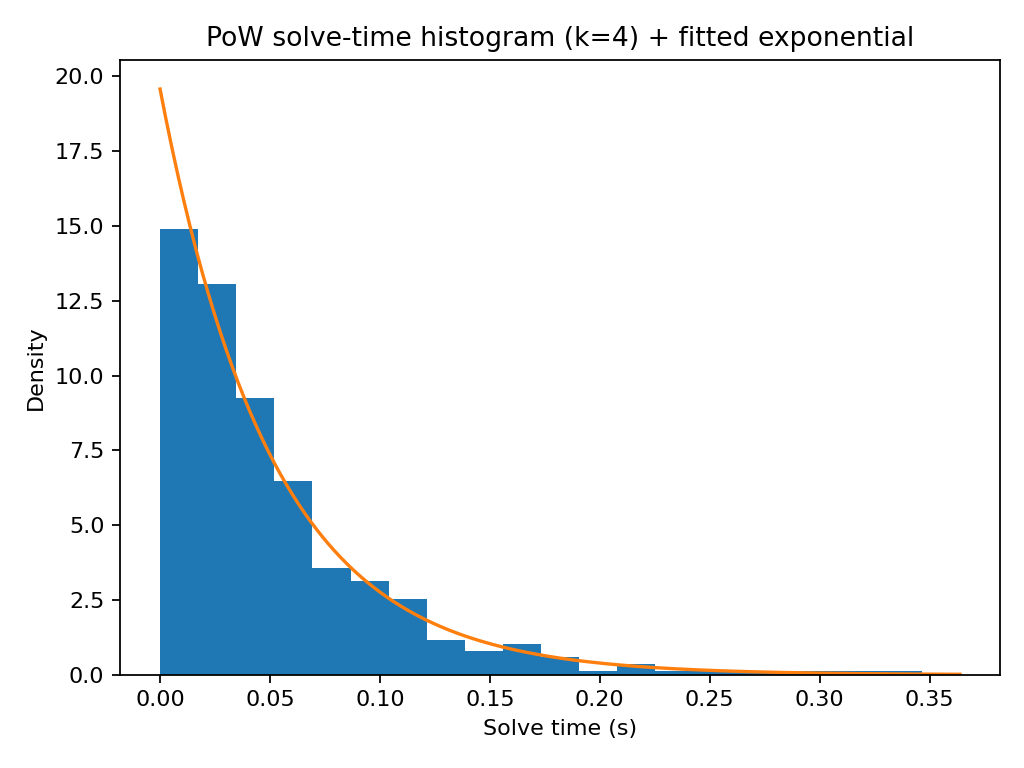

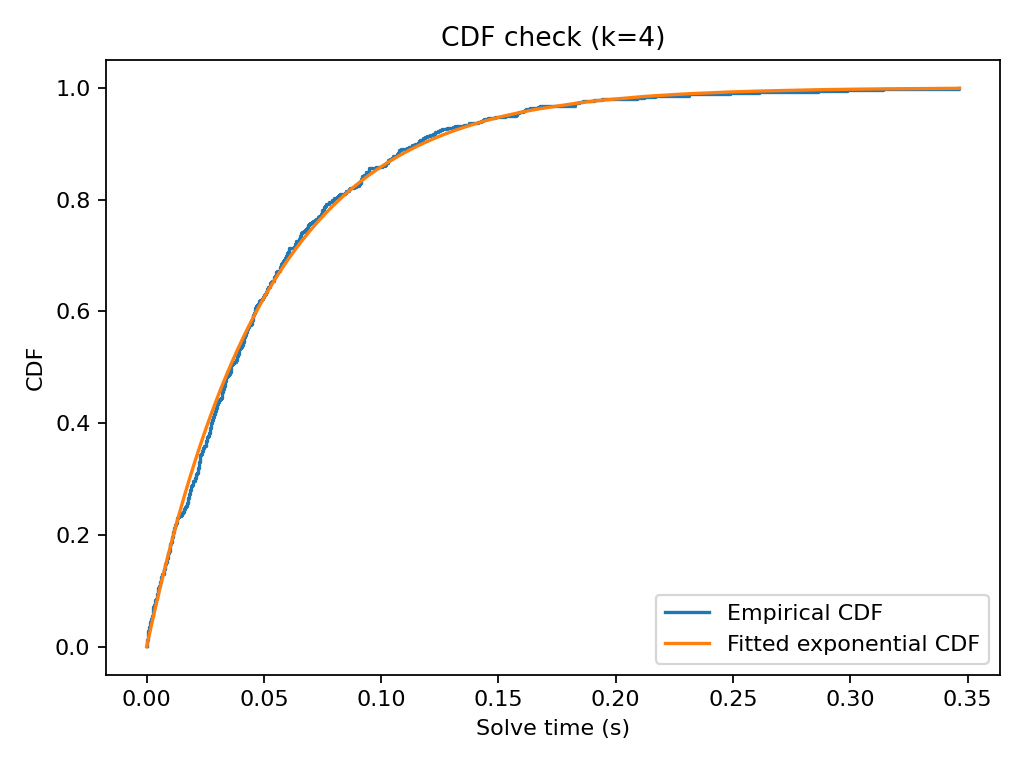

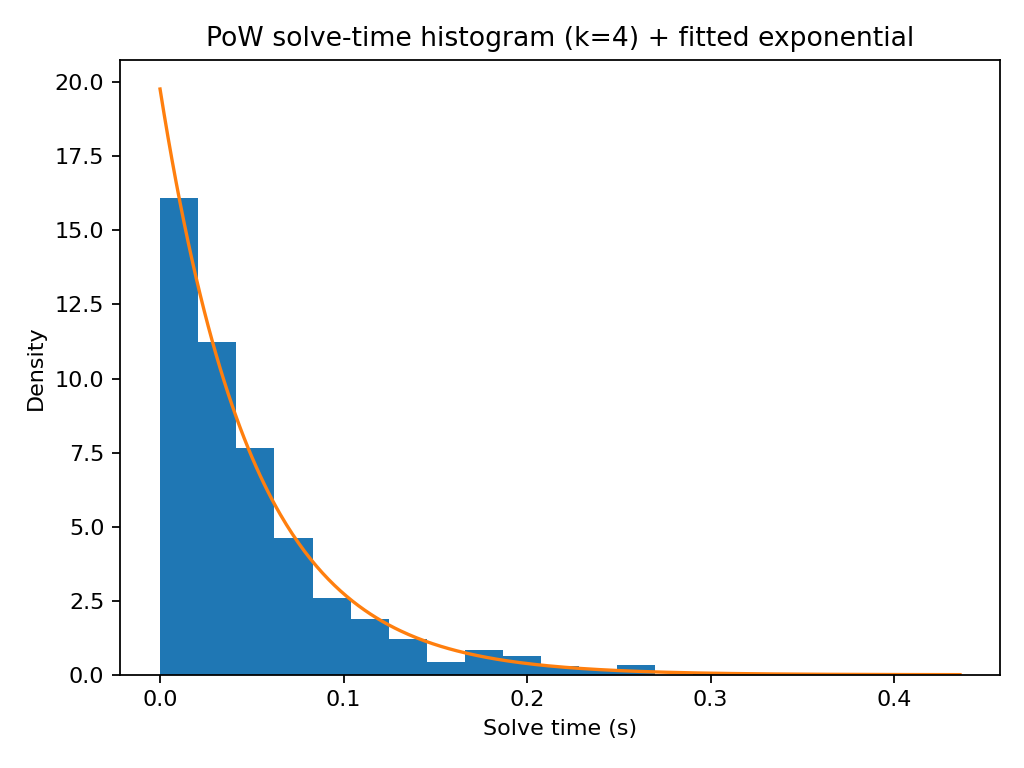

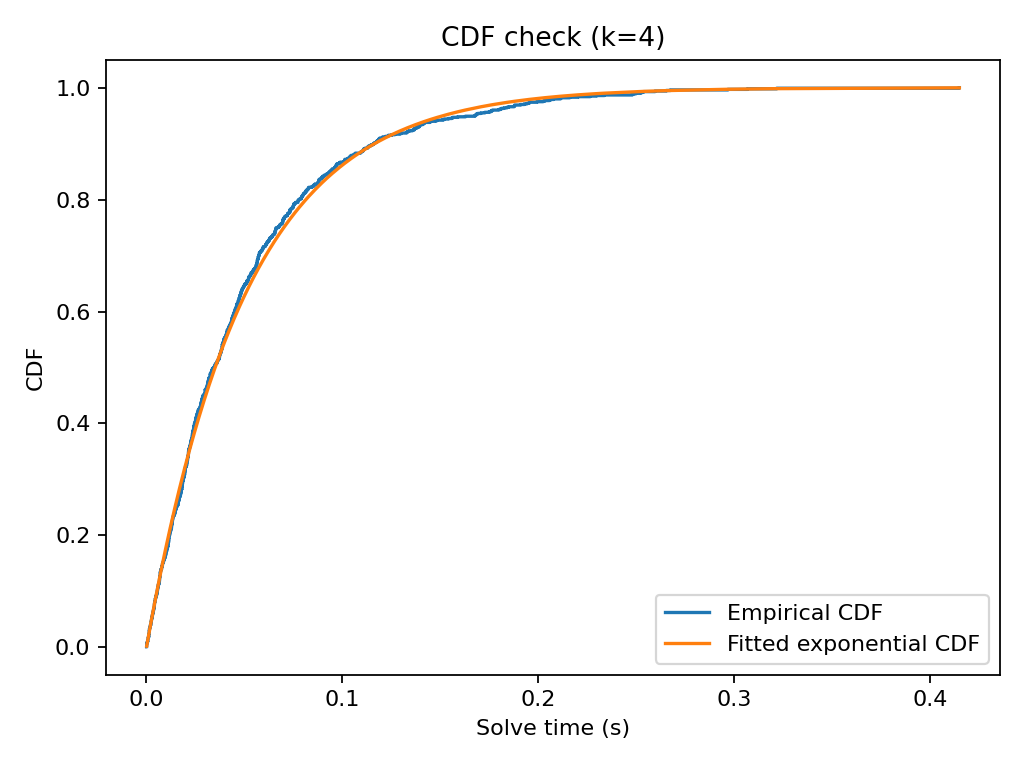

In [3]:
from IPython.display import Image, display

for n in [200, 500, 1000]:
    display(Image(f"pow_plots_{n}/hist_k4.png"))
    display(Image(f"pow_plots_{n}/cdf_k4.png"))
